# National Flood Insurance Program Data for NYC
## Claims Sample Analysis

In [1]:
# importing libraries
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
print('printing packages and versions:\n')

%reload_ext watermark
%watermark -v -p numpy,pandas,geopandas,matplotlib,seaborn

printing packages and versions:

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.22.4
pandas    : 1.4.2
geopandas : 0.9.0
matplotlib: 3.5.2
seaborn   : 0.11.2



# NFIP Claims Data Dictionary
https://www.fema.gov/openfema-data-page/fima-nfip-redacted-claims-v2

# Preview Full Data

In [3]:
%%time

path = 'data/'
all_files = glob.glob(os.path.join(path, "claims-*.json"))

# concat all counties into one dataframe
df = pd.concat((pd.read_json(file) for file in all_files), ignore_index=True)

# reverse column order
df = df.loc[:, df.columns[::-1]]

# examine data
print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (43833, 73)
CPU times: user 1.81 s, sys: 330 ms, total: 2.14 s
Wall time: 2.15 s


,id,longitude,latitude,censusBlockGroupFips,censusTract,countyCode,reportedZipCode,reportedCity,state,rentalPropertyIndicator,...,baseFloodElevation,elevationDifference,elevationCertificateIndicator,elevatedBuildingIndicator,dateOfLoss,crsClassificationCode,policyCount,basementEnclosureCrawlspaceType,asOfDate,agricultureStructureIndicator
0,7279caf2-e180-474f-9072-ce5d6382278a,-73.8,40.8,3.600501e+11,3.600501e+10,36005,10465,Currently Unavailable,NY,False,...,NaN,NaN,NaN,False,2021-09-02T00:00:00.000Z,NaN,1,0.0,2022-05-19T15:56:42.000Z,False
1,e5f8240c-06d7-48f9-b148-82040a1e5261,-73.8,40.8,3.600501e+11,3.600501e+10,36005,10465,Currently Unavailable,NY,False,...,NaN,NaN,NaN,False,2012-10-29T00:00:00.000Z,NaN,1,1.0,2020-01-22T16:55:53.000Z,False
2,abc053a4-1d37-420c-8fba-a2c97ef52dda,-73.8,40.8,3.600502e+11,3.600502e+10,36005,10465,Currently Unavailable,NY,False,...,NaN,NaN,1.0,False,2017-11-22T00:00:00.000Z,NaN,1,1.0,2020-01-22T16:55:53.000Z,False
3,7764e429-a818-48e4-ba0a-99bb50a67f5c,-73.8,40.8,3.600501e+11,3.600501e+10,36005,10465,Currently Unavailable,NY,False,...,NaN,NaN,NaN,False,2012-10-29T00:00:00.000Z,NaN,1,2.0,2020-01-22T16:55:53.000Z,False
4,a5e6a2e2-4798-47b1-bfcd-cdae0cc1d11b,-73.8,40.9,3.600505e+11,3.600505e+10,36005,10464,Currently Unavailable,NY,False,...,NaN,NaN,NaN,False,2012-10-29T00:00:00.000Z,NaN,1,1.0,2020-01-22T16:55:53.000Z,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43833 entries, 0 to 43832
Data columns (total 73 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          43833 non-null  object 
 1   longitude                                   43833 non-null  float64
 2   latitude                                    43833 non-null  float64
 3   censusBlockGroupFips                        43416 non-null  float64
 4   censusTract                                 43416 non-null  float64
 5   countyCode                                  43833 non-null  int64  
 6   reportedZipCode                             43833 non-null  object 
 7   reportedCity                                43833 non-null  object 
 8   state                                       43833 non-null  object 
 9   rentalPropertyIndicator                     43833 non-null  bool   
 10  buildingDe

# Data Wrangling

In [5]:
# convert date fields to datetime
df['dateOfLoss'] = pd.to_datetime(df['dateOfLoss'], errors='coerce')

# preview date and year loss columns
cols = ['dateOfLoss', 'yearOfLoss']

df.loc[:, cols].head()

,dateOfLoss,yearOfLoss
0,2021-09-02 00:00:00+00:00,2021
1,2012-10-29 00:00:00+00:00,2012
2,2017-11-22 00:00:00+00:00,2017
3,2012-10-29 00:00:00+00:00,2012
4,2012-10-29 00:00:00+00:00,2012


# Trends

## Count of Claims

In [6]:
year_losses = (
    df
    .groupby(by='yearOfLoss')['id']
    .count()
    .reset_index()
    .rename(columns={'id':'count'})
    .sort_values(by='yearOfLoss')
)

# preview data
year_losses.head()

,yearOfLoss,count
0,1978,2498
1,1979,4693
2,1980,4171
3,1981,1155
4,1982,812


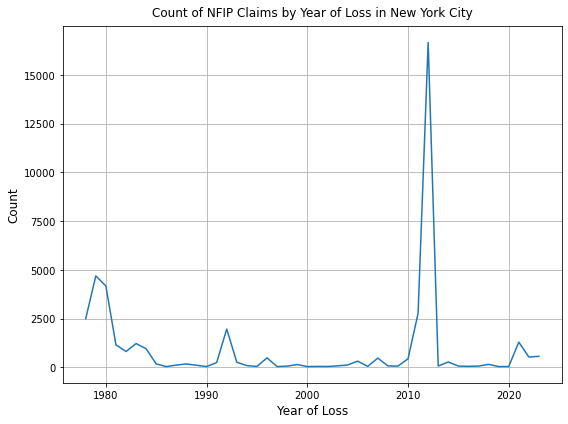

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x=year_losses['yearOfLoss'],
    y=year_losses['count'],
    color='#1f77b4'
)

label = 'Count of NFIP Claims by Year of Loss in New York City'
plt.title(label, fontsize=12, pad=10)
plt.xlabel('Year of Loss', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.grid(True)

plt.tight_layout()
plt.savefig('figures/count-claims.png', bbox_inches='tight', dpi=250)

## Total Payments

In [8]:
cols = [
    'amountPaidOnBuildingClaim',
    'amountPaidOnContentsClaim',
    'amountPaidOnIncreasedCostOfComplianceClaim'
]

df.loc[:, cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43833 entries, 0 to 43832
Data columns (total 3 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   amountPaidOnBuildingClaim                   36710 non-null  float64
 1   amountPaidOnContentsClaim                   36710 non-null  float64
 2   amountPaidOnIncreasedCostOfComplianceClaim  36710 non-null  float64
dtypes: float64(3)
memory usage: 1.0 MB


In [9]:
df['total_payments'] = (
    df['amountPaidOnBuildingClaim']
    + df['amountPaidOnContentsClaim']
    + df['amountPaidOnIncreasedCostOfComplianceClaim']
)

cols = [
    'amountPaidOnBuildingClaim',
    'amountPaidOnContentsClaim',
    'amountPaidOnIncreasedCostOfComplianceClaim',
    'total_payments'
]

df.loc[:, cols].head(10)

,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,amountPaidOnIncreasedCostOfComplianceClaim,total_payments
0,0.00,0.0,0.0,0.00
1,19917.20,0.0,0.0,19917.20
2,NaN,NaN,NaN,NaN
3,22507.96,0.0,0.0,22507.96
4,33114.30,0.0,0.0,33114.30
5,5893.95,0.0,0.0,5893.95
6,0.00,0.0,0.0,0.00
7,NaN,NaN,NaN,NaN
8,10290.09,0.0,0.0,10290.09
9,13572.46,0.0,0.0,13572.46


In [10]:
# payments in millions
payments_df = (
    df
    .groupby(by='yearOfLoss')['total_payments']
    .sum()
    .div(1_000_000)
    .reset_index()
    .sort_values(by='yearOfLoss')
)

# preview data
payments_df.head()

,yearOfLoss,total_payments
0,1978,6.634539
1,1979,12.781324
2,1980,7.723211
3,1981,2.047019
4,1982,0.727845


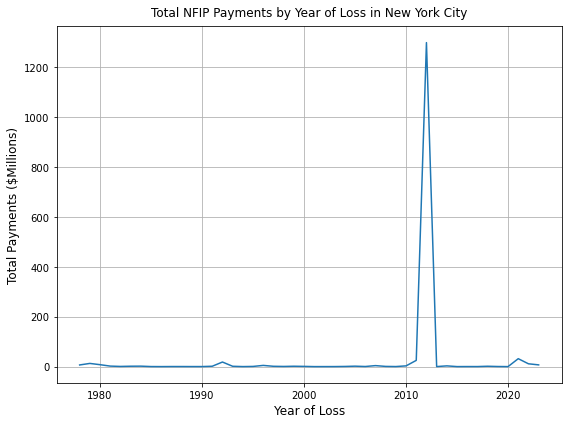

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x=payments_df['yearOfLoss'],
    y=payments_df['total_payments'],
    color='#1f77b4'
)

label = 'Total NFIP Payments by Year of Loss in New York City'
plt.title(label, fontsize=12, pad=10)
plt.xlabel('Year of Loss', fontsize=12)
plt.ylabel('Total Payments ($Millions)', fontsize=12)

plt.grid(True)

plt.tight_layout()
plt.savefig('figures/total-payments.png', bbox_inches='tight', dpi=250)